### Sentiment Analysis

The process of computationally identifying and categorizing opinions in order to determine whether the writer's attitude towards a particular topic, product, etc. is positive, negative, or neutral.

Very useful for companies in their decision making about a product.

Social Media are good sources for data to perform SA on.

### Data
We use publicly available data as form of tweets about six US airlines.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import re

%matplotlib inline

In [2]:
tweets = pd.read_csv('~/PycharmProjects/macai/nlp/data/Tweets.csv')

In [3]:
tweets.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


### Exploratory Data Analysis

Now is the time to do some EDA to get to know our data better

First let's see the distribution of airlines

United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: airline, dtype: int64


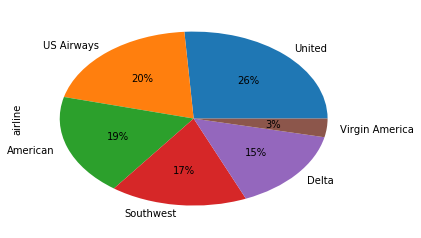

In [4]:
print(tweets['airline'].value_counts())
tweets['airline'].value_counts().plot(kind='pie', autopct='%1.0f%%')

Time to look at the distribution of sentiments

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64


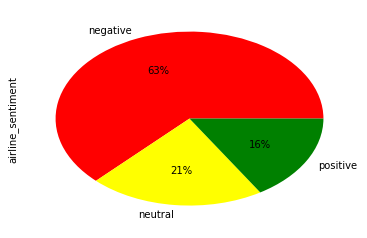

In [5]:
print(tweets['airline_sentiment'].value_counts())
tweets['airline_sentiment'].value_counts().plot(kind='pie', autopct='%1.0f%%', colors=["red", "yellow", "green"])

Not let's combine the distribution of airlines and the sentiments

airline_sentiment  negative  neutral  positive
airline                                       
American               1960      463       336
Delta                   955      723       544
Southwest              1186      664       570
US Airways             2263      381       269
United                 2633      697       492
Virgin America          181      171       152


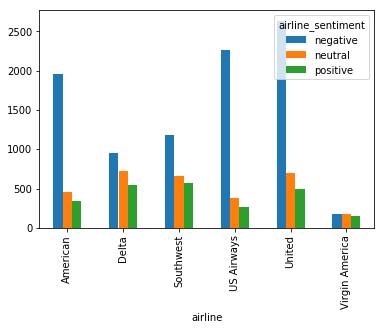

In [6]:
airline_sentiment_count = tweets.groupby(['airline', 'airline_sentiment'])['airline_sentiment'].count().unstack()
print(airline_sentiment_count)
airline_sentiment_count.plot(kind='bar')

#### How much confident are the sentiments?
Let's visualize the average confidence level for each sentiment

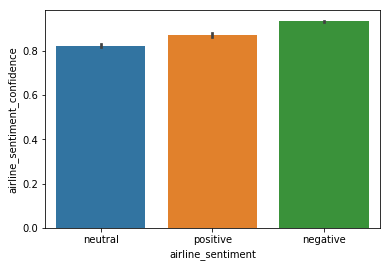

In [7]:
import seaborn as sns
sns.barplot(x='airline_sentiment', y='airline_sentiment_confidence', data=tweets)

Not bad, at least for negative sentiment. We definitely can perform
a Sentiment Analysis task on this data.

### Data Cleaning
We don't tweet in formal language. So we need to clean our data
to make sure that the training phase will work properly.


In [8]:
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer 
  
lemmatizer = WordNetLemmatizer() 
stop_words = set(stopwords.words('english')) 

# Tweet text
features = tweets['text'].values

# Tweet sentiment
labels = tweets['airline_sentiment'].values

cleaned_features = []

for tweet in features:
    # Remove all the special characters
    cleaned_tweet = re.sub(r'\W', ' ', tweet)
    
    # Lower case matters!
    cleaned_tweet = cleaned_tweet.lower()
    
    # Then remove numbers
    cleaned_tweet = re.sub(r'\d+', '', cleaned_tweet)
    
    # One space is enough!
    cleaned_tweet = re.sub(r'\s+', ' ', cleaned_tweet, flags=re.I)
    
    # But not at the beginning or end
    cleaned_tweet = cleaned_tweet.strip()
    
    # Pun not intended
    cleaned_tweet = cleaned_tweet.translate(str.maketrans('', '', string.punctuation))
    
    # No stop word (and lemmatize)
    cleaned_tweet = word_tokenize(cleaned_tweet)
    cleaned_tweet = [lemmatizer.lemmatize(w) for w in cleaned_tweet if not w in stop_words]
    cleaned_tweet = ' '.join(cleaned_tweet)
    
    cleaned_features.append(cleaned_tweet)

cleaned_features[:10]

['virginamerica dhepburn said', 'virginamerica plus added commercial experience tacky', 'virginamerica today must mean need take another trip', 'virginamerica really aggressive blast obnoxious entertainment guest face amp little recourse', 'virginamerica really big bad thing', 'virginamerica seriously would pay flight seat playing really bad thing flying va', 'virginamerica yes nearly every time fly vx ear worm go away', 'virginamerica really missed prime opportunity men without hat parody http co mwpggrezp', 'virginamerica well', 'virginamerica amazing arrived hour early good']


### Enough of cleaning, let's convert words to numbers

We use TF-IDF approach to convert the tweets into numeric vectors

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

# What are max_features, min_df, and max_df?
# Only consider the top max_features ordered by term frequency
# Ignore terms with lower frequency than min_df
# Ignore terms with presence in more than max_df of the documents
vectorizer = TfidfVectorizer(max_features=2000, min_df=7, max_df=0.8)
cleaned_features = vectorizer.fit_transform(cleaned_features).toarray()

### Train and Test division

In [10]:
from sklearn.model_selection import train_test_split

# Set random_state so that the output will be consistent
X_train, X_test, y_train, y_test = train_test_split(cleaned_features, labels, test_size=0.2, random_state=0)

### Train the model
Note that we can use the `Pipeline` method of `sklearn` to combine
the previous steps into one step. But for the sake of instruction,
we don't do that here.

#### MultinomialNB to begin with

In [11]:
from sklearn.naive_bayes import MultinomialNB

clf1 = MultinomialNB().fit(X_train, y_train)
predictions1 = clf1.predict(X_test)

#### Then LogisticRegression

In [12]:
from sklearn.linear_model import LogisticRegression

clf2 = LogisticRegression(random_state=0).fit(X_train, y_train)
predictions2 = clf2.predict(X_test)

/home/szamani/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/szamani/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


#### LinearSVC then

In [13]:
from sklearn.svm import LinearSVC

clf3 = LinearSVC().fit(X_train, y_train)
predictions3 = clf3.predict(X_test)

#### And finally RandomForestClassifier

In [14]:
from sklearn.ensemble import RandomForestClassifier

clf4 = RandomForestClassifier(n_estimators=200, random_state=0).fit(X_train, y_train)
predictions4 = clf4.predict(X_test)

### Results

In [15]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print('Result for MultinomialNB: ')
print()
print(confusion_matrix(y_test, predictions1))
print(classification_report(y_test, predictions1))
print(accuracy_score(y_test, predictions1))
print('\n##############################################\n')

print('Result for LogisticRegression: ')
print()
print(confusion_matrix(y_test, predictions2))
print(classification_report(y_test, predictions2))
print(accuracy_score(y_test, predictions2))
print('\n##############################################\n')

print('Result for LinearSVC: ')
print()
print(confusion_matrix(y_test, predictions3))
print(classification_report(y_test, predictions3))
print(accuracy_score(y_test, predictions3))
print('\n##############################################\n')

print('Result for RandomForestClassifier: ')
print()
print(confusion_matrix(y_test, predictions4))
print(classification_report(y_test, predictions4))
print(accuracy_score(y_test, predictions4))


Result for MultinomialNB: 

[[1816   43   11]
 [ 380  211   23]
 [ 214   38  192]]
              precision    recall  f1-score   support

    negative       0.75      0.97      0.85      1870
     neutral       0.72      0.34      0.47       614
    positive       0.85      0.43      0.57       444

    accuracy                           0.76      2928
   macro avg       0.78      0.58      0.63      2928
weighted avg       0.76      0.76      0.73      2928

0.7578551912568307

##############################################

Result for LogisticRegression: 

[[1761   84   25]
 [ 299  273   42]
 [ 134   51  259]]
              precision    recall  f1-score   support

    negative       0.80      0.94      0.87      1870
     neutral       0.67      0.44      0.53       614
    positive       0.79      0.58      0.67       444

    accuracy                           0.78      2928
   macro avg       0.76      0.66      0.69      2928
weighted avg       0.77      0.78      0.77      2928
